# 911 Calls - Data Analysis

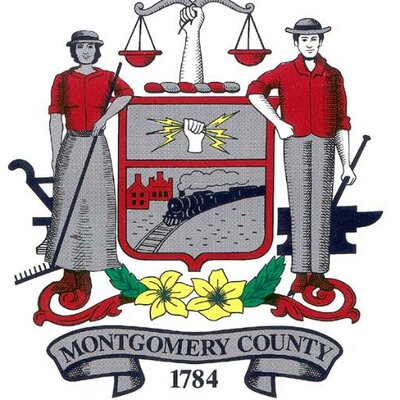

- The purpose of this project is to provide a brief data analysis of a 911 calls dataset.
- The dataset contains emergency calls data from Montgomery County, Pennsylvania. 

## Setup

In [ ]:
# Importing the main libraries
import numpy as np
import pandas as pd

# Notebook settings
%matplotlib inline

# Importing data visualization libraries
import plotly.express as px
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

# Data visualization settings
sns.set_style("darkgrid")

# Disabling warnings
import warnings; warnings.simplefilter('ignore')

## Dataset Overview

In [ ]:
# Loading the dataset
df = pd.read_csv('/kaggle/input/montcoalert/911.csv')

In [ ]:
# Checking the dataset variables
df.info()

In [ ]:
# Viewing a sample of the dataset
df.head()

In [ ]:
# Showing min and max dates
print(df['timeStamp'].min())
print(df['timeStamp'].max())

The dataset has 633701 rows, each one representing a call, from December 2015 to May 2020.
It contains the following fields:

* lat : String variable, Latitude
* lng: String variable, Longitude
* desc: String variable, Description of the Emergency Call
* zip: String variable, Zipcode
* title: String variable, Title
* timeStamp: String variable, YYYY-MM-DD HH:MM:SS
* twp: String variable, Township
* addr: String variable, Address
* e: String variable, Dummy variable (always 1)

From this initial analysis, the dataset information can be resumed in three aspects:

- Call reason
- Call time
- Call location

From this aspects, we can formulate some questions that we will investigate further:

1. What are the most common reasons for a 911 call?
2. How are the calls distributed in time?
3. How are the calls distributed geographically? 


## Exploratory Data Analysis

In [ ]:
# The reason for the call is represented by the title column, composed by a category and a subcategory
# Therefore, we will begin by splitting this column into two new columns
df['Category'] = df['title'].apply(lambda x: x.split(': ')[0])
df['Subcategory'] = df['title'].apply(lambda x: x.split(': ')[1])

In [ ]:
# Checking the new columns in the dataset
df.head()

In [ ]:
# Now, we can investigate the most common reasons for a call
# First, we will see how the calls are distributed by category
df['Category'].value_counts()

In [ ]:
# In order to better visualize, we can plot the above information
plt.figure(figsize=(14,7))

sns.countplot(x="Category", data=df, palette='viridis', order=df['Category'].value_counts().index)

plt.title('911 Calls by Category')
plt.xlabel('Category')
plt.ylabel('Number of Calls')

In [ ]:
# The same can be done to see the subcategories with most calls
# In order not to lose the category information, we will use the title column

plt.figure(figsize=(14,7))

sns.countplot(x="title", data=df, palette='Accent', order=df['title'].value_counts().head().index)

plt.title('911 Calls by Subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)

In [ ]:
# Now, for example, let's explore the most representative subcategories in the EMS category
plt.figure(figsize=(12,6))

sns.barplot(x=df[df['Category'] == 'EMS']['Subcategory'].value_counts().head(), 
            y=df[df['Category'] == 'EMS']['Subcategory'].value_counts().head().index,
            data=df[df['Category'] == 'EMS'], palette='Spectral', orient='h')

plt.title('EMS - 911 Calls by Subcategory')
plt.xlabel('Number of Calls')
plt.ylabel('Subcategory')

From the information above, we can draw some conclusions:

- EMS (Emergency Medical Services) accounts for almost half the total of 911 calls in the period
- Vehicle accident is by far the most common 911 call reason
- Although fall victim ranks first in EMS call reasons, it only represents around 5% of total calls
- Fire alarm represents almost 40% of fire related 911 calls

In [ ]:
# To explore the calls in the studied period, we will use the timeStamp column
# First, we have to convert the timeStamp column from string to datetime
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [ ]:
# Now we can create three new columns to better explore the data
df['Date'] = df['timeStamp'].apply(lambda x: x.date())
df['Day of Week'] = df['timeStamp'].apply(lambda x: x.strftime("%a"))
df['Hour'] = df['timeStamp'].apply(lambda x: x.strftime("%H"))

In [ ]:
# Let's see how the dataframe is now
df.head()

In [ ]:
# Initially, we can plot a heatmap to see which hours of the day and days of the week the number of calls are higher
# Data for the plot
byDayHour = df.groupby(['Day of Week','Hour']).size().reset_index().rename(columns={0:'Number of Calls'})
byDayHour_df = pd.pivot_table(data=byDayHour,values='Number of Calls',index='Day of Week',columns='Hour',aggfunc='sum')
byDayHour_df.index = pd.CategoricalIndex(byDayHour_df.index, categories=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][::-1])
byDayHour_df.sort_index(level=0, inplace=True)

# Plot
plt.figure(figsize=(15,8))
sns.heatmap(data = byDayHour_df, cmap='magma', linecolor='grey', linewidth=0.2)
plt.title('911 Calls by Day of Week and Hour')

The plot above shows that the 911 calls occurs mostly from **8:00 to 18:00**, and decreases gradually as the night advances.

In [ ]:
# In another analysis, we will plot a line plot containing the calls in the period, segregated by the category of the call
byDateCategory = df.groupby(['Date','Category']).size().reset_index().rename(columns={0:'Number of Calls'})

plt.figure(figsize=(15,7))

sns.lineplot(x='Date',y='Number of Calls',data=byDateCategory, hue='Category', palette='Set2')
plt.xticks(rotation=45)
plt.title('911 Calls - Evolution')

In [ ]:
# Analyzing the plot above, we can clearly see several spikes in traffic related calls
# Let's see now the dates with higher occurrences and the exact number of calls
df[df['Category'] == 'Traffic'].groupby('Date').size().reset_index() \
                               .rename(columns={0:'Number of Calls'}) \
                               .sort_values('Number of Calls', ascending = False) \
                               .head(10)

After a search on Google, we see that the cause for a high number of calls in **March 2nd, 2018** was a powerful **nor'easter (cyclone)** that impacted the region.

In [ ]:
# Let's isolate the traffic category for better visualization and make the plot interactive using Plotly library
fig = px.line(byDateCategory[byDateCategory['Category'] == 'Traffic'], x="Date", y="Number of Calls",
              template='seaborn', title='Traffic Calls - Evolution')

fig.add_shape( # add a horizontal line, representing mean
    type="line", line_color="orange", line_width=3, opacity=1, line_dash="dot",
    x0=0, x1=1, xref="paper", y0=byDateCategory['Number of Calls'].mean(),
    y1=byDateCategory['Number of Calls'].mean(), yref="y"
)

fig.add_annotation( # add a text for the nor'easter
    text="March 1-3, 2018 nor'easter", x='2018-03-02', y=1350, arrowhead=1, showarrow=True, arrowcolor='red' 
)

In [ ]:
# March 1-3, 2018 Nor'easter

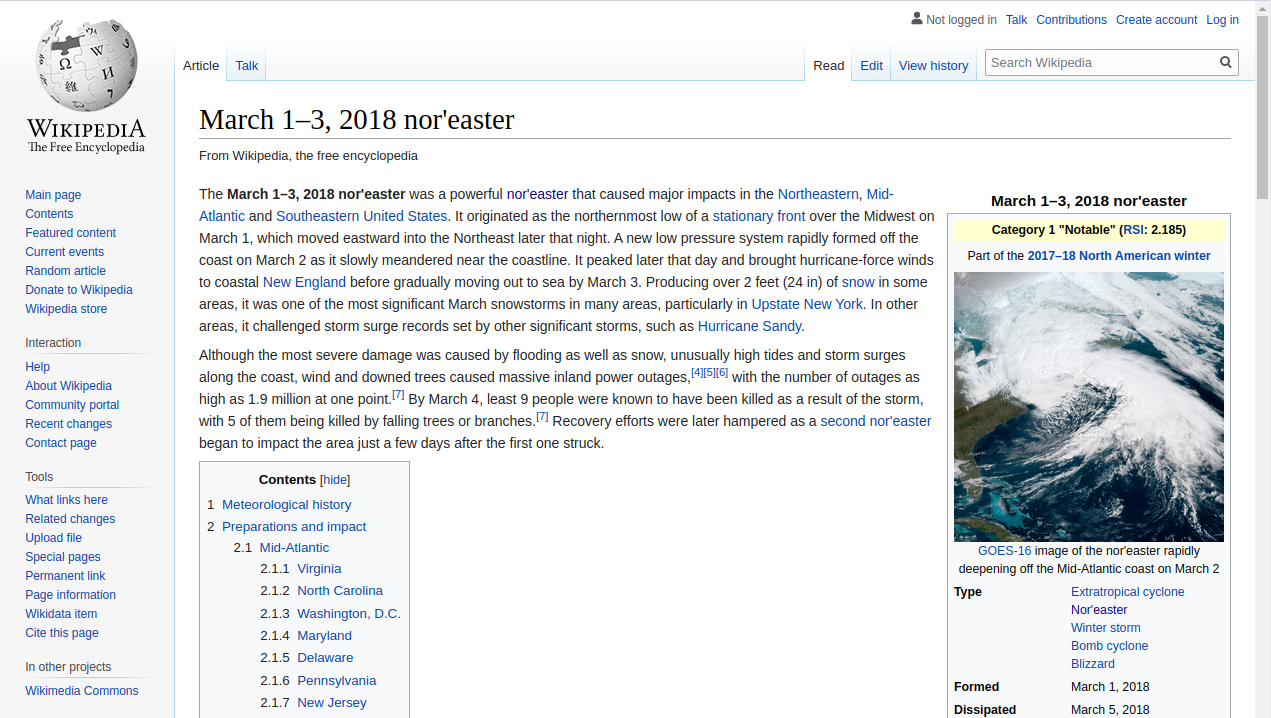

In [ ]:
# Now let's see the 911 call subcategories in traffic in that day
df[(df['Category'] == 'Traffic') & (df['Date'].astype(str) == '2018-03-02')] \
  .groupby('Subcategory') \
  .size() \
  .reset_index() \
  .rename(columns={0:'Number of Calls'}) \
  .sort_values('Number of Calls', ascending = False) 

We can see that almost half of calls that day had **road obstruction** as a reason. This makes sense since in a severe cyclone, down trees and power lines are usual.

Now we will explore the locations of the 911 calls represented in the dataset. For this task, we need a dataset/layer that represents the townships' boundaries. Luckily, we've found what we need in the [Mountgomery County website][1].

[1]: https://data-montcopa.opendata.arcgis.com/datasets/montgomery-county-municipal-boundaries

In [ ]:
# Loading the geojson file containing the township boundaries with the geopandas library
montgomery_map = gpd.read_file('https://opendata.arcgis.com/datasets/74f1d8fde3204995916dc377e8db0dbc_0.geojson')

In [ ]:
# Verifying the type of the object
type(montgomery_map)

In [ ]:
# Viewing a sample of the dataset
montgomery_map.head()

Now we have to verify if the townships available on this file are the ones we have on the 911 calls dataset.

In [ ]:
# Verifying the difference between the townships in both datasets
set(montgomery_map['Name'].str.lower()) - set(df['twp'].str.lower())

In [ ]:
# Tranforming the Name column in the map dataframe to be equal the twp column in the df dataframe
# Aplying the title function (making the first letter in each word upper case)
df['twp'] = df['twp'].str.title()
# Correcting the difference in the writing of the Hatfield Township
montgomery_map['Name'].replace('Hatfield Twp','Hatfield Township',inplace=True)

Our purpose now is to enrich the map dataframe with the calls info from the 911 dataset. With the conclusion of the previous steps, we can use the columns that represent the township in both datasets as a key to join them.

In [ ]:
# Creating a dataframe containing the 911 calls by township
calls_df = df['twp'].value_counts().reset_index().rename(columns={'index':'Township','twp':'Number of Calls'})
calls_df.head()

In [ ]:
# Merging the calls_df dataframe with the montgomery_map dataframe
merged_df = pd.merge(montgomery_map, calls_df, how='left', left_on='Name', right_on='Township')
merged_df.head()

In [ ]:
# Now, we can use the folium library to plot an interactive choropleth map
# Setting the coordinates for the map
folium_map = folium.Map(location=[40.2, -75.4], zoom_start=10)

# Creating the choropleth layer
choropleth = folium.Choropleth(merged_df, data=merged_df,
                  key_on='feature.properties.Township',
                  columns=['Township', 'Number of Calls'], 
                  fill_color='Reds', fill_opacity = 0.7,
                  line_opacity=0.3, highlight=True,
                  name='Montgomery County', legend_name='Number of Calls',).add_to(folium_map)

# Adding the layer to the map
folium.LayerControl().add_to(folium_map)

# Adding the tooltip to the map
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['Township','Number of Calls'])
)

# Displaying the map
folium_map

From the map above, we can see that the townships with most calls are **Lower Merion (53240)**, **Abington (38208)** and **Norristown (35678)**. Now, let's dig deeper into the Lower Merion township by plotting a heatmap with the lat and lng info we have, in order to see how the calls were distributed geographically.

In [ ]:
# Creating a basemap centered in the Lower Merion Township region
basemap = folium.Map(location=[40.0250, -75.2850], zoom_start=12)

# Creating lists with lat and lng data points
lat = df[df['twp'] == 'Lower Merion'].lat.tolist()
lng = df[df['twp'] == 'Lower Merion'].lng.tolist()

# Adding the heatmap layer
HeatMap(list(zip(lat, lng)),radius=10,).add_to(basemap)

# Plotting the map
basemap

## Conclusions

As stated above, the purpose of this project was to provide a brief data analysis of the dataset in order to answer some basic questions. The answers for the questions are summarized below:

- EMS (Emergency Medical Services) accounted for almost half the total of 911 calls in the period
- Vehicle accident was by far the most common 911 call reason
- Although fall victim ranked first in EMS call reasons, it only represented around 5% of total calls
- Fire alarm represented almost 40% of fire related 911 calls
- 911 calls occured mostly from 8:00 to 18:00, decreasing into the night
- In all categories, the number of calls over time didn't vary substantially, mantaining a certain pattern. Nevertheless, the occurence of events such as climate ones, affected the number of traffic calls in several moments.
- Lower Merion, Abington and Norristown townships represented one out of five calls made.